# AIDS: experiments

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

from tdsurv import CoxPH, concordance_index, unroll

## Adding positional information helps

In [2]:
with open("../data/aids-seqs.pkl", "rb") as f:
    data = pickle.load(f)

seqs = data["seqs"]
cs = data["cs"]
ts = data["ts"]
cols = data["cols"]

n, horizon, _ = seqs.shape
seqs = np.concatenate((seqs, np.tile(np.eye(horizon), (n, 1, 1))), axis=-1)

d = seqs.shape[2]

In [3]:
seqs_, ts_, cs_ = unroll(seqs, ts, cs)

model = CoxPH(horizon=horizon, n_feats=d)
model.fit(seqs_, ts_, cs_, lambda_=1.0, l2=0.5)

Text(0.5, 1.0, 'Coefficients of positional features')

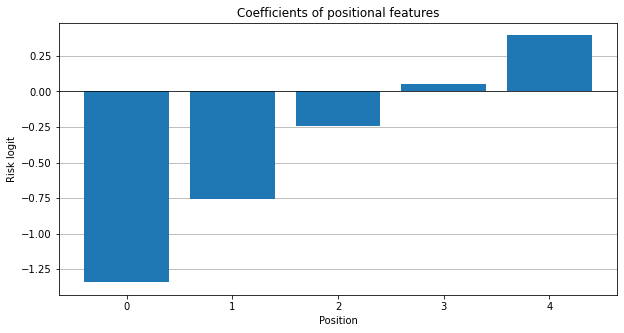

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))
idx = np.arange(horizon)
ax.bar(idx, model.params[d-horizon:d])
ax.set_xticks(idx)
ax.axhline(0.0, color="black", lw=0.7)
ax.grid(axis="y")
ax.set_axisbelow(True)
ax.set_xlabel("Position")
ax.set_ylabel("Risk logit")
ax.set_title("Coefficients of positional features")

**Conclusion**: adding position information is likely to help.

## Sample efficiency

In [5]:
with open("../data/aids-seqs.pkl", "rb") as f:
    data = pickle.load(f)

seqs = data["seqs"]
cs = data["cs"]
ts = data["ts"]
cols = data["cols"]

n, horizon, _ = seqs.shape
seqs = np.concatenate((seqs, np.tile(np.arange(horizon), (n, 1))[:, :, None]), axis=-1)

d = seqs.shape[2]
n_feats = d - 1

In [6]:
# Pseudo ground-truth parameters
model = CoxPH(horizon=horizon, n_feats=d)
model.fit(seqs, ts, cs, lambda_=1.0, l2=0.01)
params_gt = model.params[:n_feats]

In [7]:
# 5-fold cross-validation
rng = np.random.default_rng(seed=0)
n_folds = 5
zs = np.append(((n / n_folds) * np.arange(n_folds)).astype(int), n)
idx = rng.permutation(n)

def get_fold(fold):
    z1 = zs[fold]
    z2 = zs[fold + 1]
    idx_train = np.concatenate((idx[:z1], idx[z2:]))
    idx_valid = idx[z1:z2]
    return (
        (seqs[idx_train], ts[idx_train], cs[idx_train]),
        (seqs[idx_valid], ts[idx_valid], cs[idx_valid]),
    )

sizes = np.arange(20, 201, step=20)

def experiment(fn, vals):
    model = CoxPH(horizon=horizon, n_feats=d)
    res = np.zeros((n_folds, len(sizes), len(vals), 4))
    for fold in range(n_folds):
        (seqs_t, ts_t, cs_t), (seqs_v, ts_v, cs_v) = get_fold(fold)
        for i, size in enumerate(sizes):
            print(".", end="")
            for j, val in enumerate(vals):
                fn(model, val, seqs_t[:size], ts_t[:size], cs_t[:size])
                res[fold, i, j, 0] = model.loglike(seqs_v[:, 0], ts_v, cs_v)
                res[fold, i, j, 1] = model.integrated_brier_score(seqs_v[:, 0], ts_v, cs_v)
                res[fold, i, j, 2] = concordance_index(model.score(seqs_v[:, 0]), ts_v, cs_v)
                res[fold, i, j, 3] = np.linalg.norm(model.params[:n_feats] - params_gt)
        print()
    return res


def plot_res(res, vals):
    mean = res.mean(axis=0)
    #std = res.std(axis=0)
    fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(16, 10))
    for j, val in enumerate(vals):
        for k, ax in enumerate(axs.ravel()):
            ax.plot(sizes, mean[:, j, k], marker="o", label=f"val = {val:.3f}")
    for ax in axs.ravel():
        ax.legend()
        ax.grid()
    axs[1,0].set_xlabel("Number of patients")
    axs[1,1].set_xlabel("Number of patients")
    axs[0,0].set_title("Predictive log-likelihood")
    axs[0,1].set_title("Integrated Brier score")
    axs[1,0].set_title("Concordance index")
    axs[1,1].set_title("RMSE to ground-truth params")
    return (fig, axs)

### Initial state

In [8]:
%%time
def initial_state(model, l2, seqs, ts, cs):
    model.params = np.zeros_like(model.params)
    model.fit(seqs, ts, cs, lambda_=1.0, l2=l2)

l2s = np.array([0.001, 0.01, 0.1, 0.5, 1.0, 10.0])
res_is = experiment(initial_state, l2s)

..........
..........
..........
..........
..........
CPU times: user 19.7 s, sys: 160 ms, total: 19.9 s
Wall time: 19.7 s


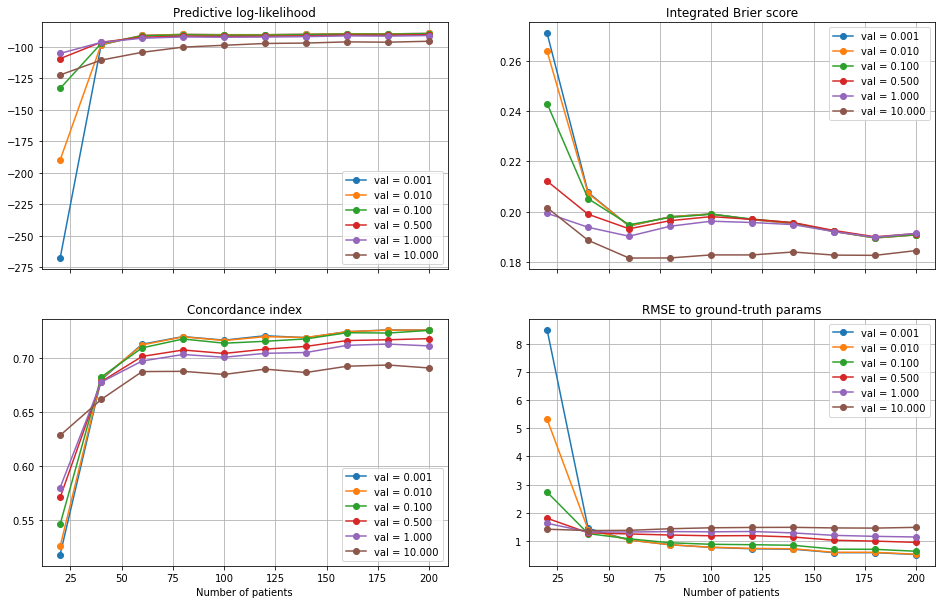

In [9]:
fig, axs = plot_res(res_is, l2s);

### Landmarking

In [10]:
%%time
def landmarking(model, l2, seqs, ts, cs):
    model.params = np.zeros_like(model.params)
    seqs_, ts_, cs_ = unroll(seqs, ts, cs)
    model.fit(seqs_, ts_, cs_, lambda_=1.0, l2=l2)

l2s = np.array([0.01, 0.05, 0.1, 0.3, 1.0, 10.0])
res_lm = experiment(landmarking, l2s)

..........
..........
..........
..........
..........
CPU times: user 22 s, sys: 356 ms, total: 22.3 s
Wall time: 21.1 s


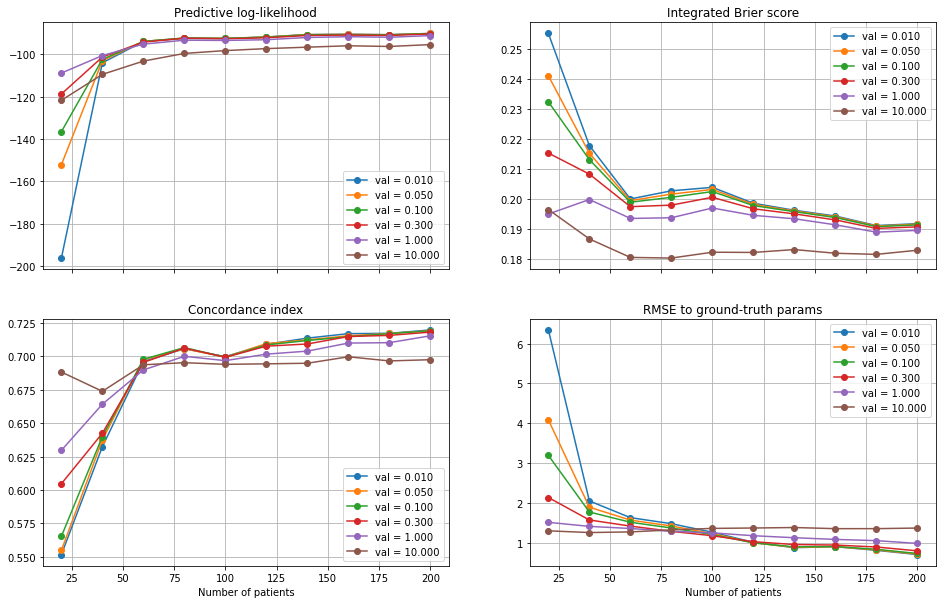

In [11]:
fig, axs = plot_res(res_lm, l2s);

### Temporal Difference

Different regularization strengths

In [12]:
%%time
def temporal_difference_l2(model, l2, seqs, ts, cs):
    model.params = np.zeros_like(model.params)
    seqs_, ts_, cs_ = unroll(seqs, ts, cs)
    model.fit(seqs_, ts_, cs_, lambda_=0.0, n_iters=30, l2=l2)

l2s = np.array([0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0])
res_td = experiment(temporal_difference_l2, l2s)

..........
..........
..........
..........
..........
CPU times: user 1min 31s, sys: 2.61 s, total: 1min 34s
Wall time: 1min 20s


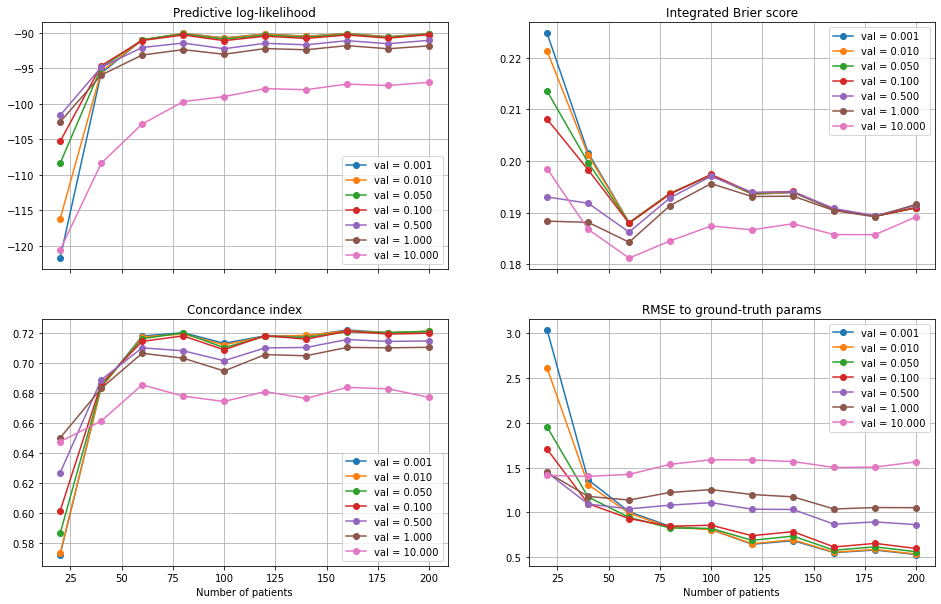

In [13]:
plot_res(res_td, l2s);

Different trace decays.

In [14]:
%%time
def temporal_difference_lambda(model, lambda_, seqs, ts, cs):
    model.params = np.zeros_like(model.params)
    seqs_, ts_, cs_ = unroll(seqs, ts, cs)
    model.fit(seqs_, ts_, cs_, lambda_=lambda_, n_iters=30, l2=0.0)

lambdas = np.array([0.0, 0.2, 0.5, 1.0])
res_td2 = experiment(temporal_difference_lambda, lambdas)

..........
..........
..........
..........
..........
CPU times: user 1min 13s, sys: 1.29 s, total: 1min 14s
Wall time: 1min 8s


(-100.0, -80.97925235465645)

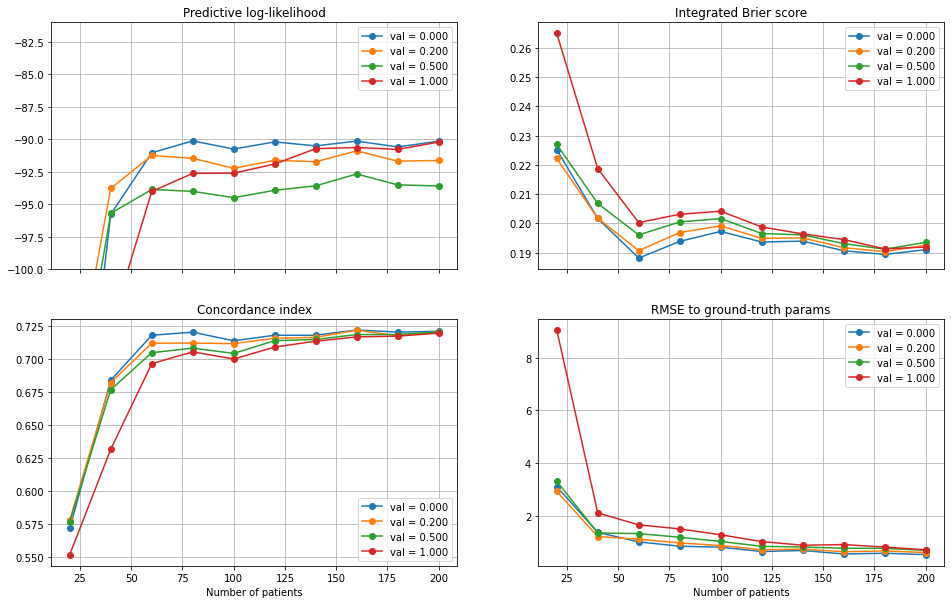

In [15]:
fig, axs = plot_res(res_td2, lambdas)
axs[0,0].set_ylim(ymin=-100)